From https://docs.dgl.ai/en/0.6.x/new-tutorial/5_graph_classification.html

In [1]:
import dgl
from dgl.data import DGLDataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import scipy.sparse as sp
import networkx as nx
import itertools
import json

Using backend: pytorch


In [2]:
with open('../data/twitch_egos/twitch_edges.json', 'r') as f:
    edges_json = json.load(f)

edges_list = []
for g in edges_json:
    for edge in edges_json[g]:
        edges_list.append([g, edge[0], edge[1]])

edges = pd.DataFrame(edges_list, columns=['graph_id', 'source', 'target'])

In [3]:
properties = pd.read_csv('../data/twitch_egos/twitch_target.csv', header=0)
properties['num_nodes'] = [len(edges_json[g]) for g in edges_json]
properties = properties.rename(columns={"id": "graph_id", "target": "label"})

In [4]:
class TwitchEgosDataset(DGLDataset):
    def __init__(self):
        super().__init__(name='twitch_egos')

    def process(self):
        #edges = pd.read_csv('./graph_edges.csv')
        #properties = pd.read_csv('./graph_properties.csv')
        self.graphs = []
        self.labels = []

        # Create a graph for each graph ID from the edges table.
        # First process the properties table into two dictionaries with graph IDs as keys.
        # The label and number of nodes are values.
        label_dict = {}
        num_nodes_dict = {}
        for _, row in properties.iterrows():
            label_dict[row['graph_id']] = row['label']
            num_nodes_dict[row['graph_id']] = row['num_nodes']

        # For the edges, first group the table by graph IDs.
        edges_group = edges.groupby('graph_id')

        # For each graph ID...
        for graph_id in edges_group.groups:
            # Find the edges as well as the number of nodes and its label.
            edges_of_id = edges_group.get_group(graph_id)
            src = edges_of_id['source'].to_numpy()
            dst = edges_of_id['target'].to_numpy()
            num_nodes = num_nodes_dict[int(graph_id)]
            label = label_dict[int(graph_id)]

            # Create a graph and add it to the list of graphs and labels.
            g = dgl.graph((src, dst), num_nodes=num_nodes+1)
            self.graphs.append(g)
            self.labels.append(label)

        # Convert the label list to tensor for saving.
        self.labels = torch.LongTensor(self.labels)

    def __getitem__(self, i):
        return self.graphs[i], self.labels[i]

    def __len__(self):
        return len(self.graphs)

dataset = TwitchEgosDataset()
graph, label = dataset[0]
print(graph, label)

Graph(num_nodes=88, num_edges=87,
      ndata_schemes={}
      edata_schemes={}) tensor(0)


In [5]:
from dgl.nn import GraphConv
import torch.nn as nn
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(Classifier, self).__init__()
        self.conv1 = GraphConv(in_dim, hidden_dim)
        self.conv2 = GraphConv(hidden_dim, hidden_dim)
        self.classify = nn.Linear(hidden_dim, n_classes)
        #print(f"n_classes, {n_classes}")
    def forward(self, g):
        # Use node degree as the initial node feature. For undirected graphs, the in-degree
        # is the same as the out_degree.
        h = g.in_degrees().view(-1, 1).float()
        # Perform graph convolution and activation function.
        h = F.relu(self.conv1(g, h))
        h = F.relu(self.conv2(g, h))
        g.ndata['h'] = h
        #print(f"h.size, {h.size()}")
        # Calculate graph representation by averaging all the node representations.
        hg = dgl.mean_nodes(g, 'h')
        #print(f"hg.size, {hg.size()}")
        return self.classify(hg)

In [6]:
from dgl.dataloading import GraphDataLoader
from torch.utils.data.sampler import SubsetRandomSampler

num_examples = len(dataset)
num_train = int(num_examples * 0.8)

train_sampler = SubsetRandomSampler(torch.arange(num_train))
test_sampler = SubsetRandomSampler(torch.arange(num_train, num_examples))

train_dataloader = GraphDataLoader(
    dataset, sampler=train_sampler, batch_size=1, drop_last=False)
test_dataloader = GraphDataLoader(
    dataset, sampler=test_sampler, batch_size=1, drop_last=False)

In [7]:
def evaluate(model, graph, labels):
    model.eval()
    with torch.no_grad():
        logits = model(graph)
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)

In [8]:
import torch
torch.cuda.is_available()

True

In [13]:
model = Classifier(1, 100, 2)
opt = torch.optim.Adam(model.parameters())
logs = []

epoch_losses = []
for epoch in range(10):
    epoch_loss = 0
    for iter, (bg, label) in enumerate(train_dataloader):
        model.train()
        # forward propagation by using all nodes
        bg = dgl.add_self_loop(bg)
        logits = model(bg)
        # compute loss
        loss = F.cross_entropy(logits, label)
        # backward propagation
        opt.zero_grad()
        loss.backward()
        opt.step()
        

    for iter, (bg, label) in enumerate(test_dataloader):
        # compute test accuracy
        bg = dgl.add_self_loop(bg)
        test_acc = evaluate(model, bg, label)
        logs.append([loss, test_acc])


    if epoch % 1 == 0:
        print('In epoch {}, loss: {:.3f}, test acc: {:.3f}'.format(
            epoch, loss, test_acc))

In epoch 0, loss: 0.731, test acc: 1.000
In epoch 1, loss: 0.700, test acc: 1.000
In epoch 2, loss: 0.355, test acc: 1.000


KeyboardInterrupt: 

In [ ]:
# Max acc
max(np.array(logs)[:,1])

2.9670262

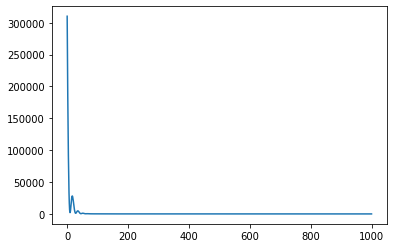

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.array(logs)[:,0])

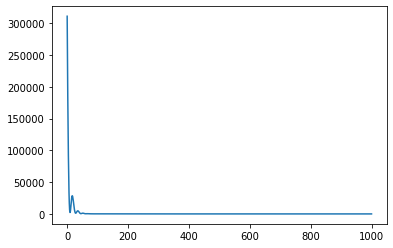

In [ ]:
plt.plot(np.array(logs)[:,1])